In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from lpdensity import lpdensity


In [46]:
df = pd.read_stata("data_cont_training_YF_jan1824.dta")
col_name= ['edu', 'prevearn', 'earnings','wkforpy', 'weekswrk','adultm', 'age', 'bfeduca', 'bfvococc',
       'bfabeesl', 'bfwforpy', 'bfjbclub', 'bfmarsta', 'bftotinc', 'bfnoafdc',
       'bfpbhous', 'bfmandat', 'portuges', 'tagalog', 'nohs', 'numdeg', 
       'yearearn', 'recafdc', 'anyafdcy', 'corpus', 'cedar', 'coosa', 'heart', 'fortw', 'jersey',
       'jackson', 'larimar', 'decatur', 'nwminn', 'montana', 'omaha', 'marion',
       'oakland', 'provid', 'springf', 'ctonly', 'ojtonly', 'actothr', 'adultf', 'youthm', 'youthn', 'numrecs',
       'numothr', 'white', 'black', 'hispanic', 'native', 'asian', 'wht_blk',
       'w_b_his', 'female', 'ramonth', 'cohort',  'phonehom', 'hour_train']
df = df[col_name]

for x in df.columns:
    if np.max(df[x]) == 9 and len(np.unique(df[x])) == 3:
       df.loc[df[x]==9, x] = np.nan 
    elif np.max(df[x]) == 99:
        df.loc[df[x]==99, x] = np.nan 
    elif np.max(df[x]) == 999:
        df.loc[df[x]==999, x]= np.nan 
    elif np.max(df[x]) == 9999:
        df.loc[df[x]==9999, x] = np.nan 


keep_column = df.columns[df.isnull().sum() == 0]
data = df[keep_column]

# # restrict the sample to be plausible
data = data[data['prevearn']<=20000]
data = data[data['hour_train']<3000]
# data = data[data['hour_train']<1360]
data = data[data["earnings"]<=80000]
data["week_train"] = data["hour_train"]/40

<Axes: >

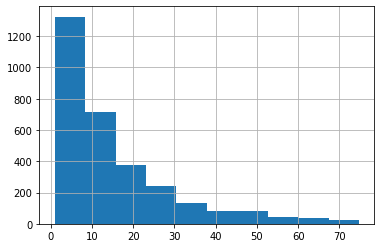

In [51]:
data["week_train"].hist()

In [53]:
# 4. Calculate parameters
week_train = data['week_train'].values
bins = 80
hist_range = (week_train.min(), week_train.max())
bin_width = (hist_range[1] - hist_range[0]) / bins

# 5. Create grid
grid_points = np.linspace(hist_range[0], hist_range[1], bins)

    # Make sure all inputs are the correct type
week_train_array = np.array(week_train, dtype=float)
bin_width_float = float(bin_width)
grid_array = np.array(grid_points, dtype=float)
density_est = lpdensity(week_train_array, bw=[bin_width], grid=grid_array)
           

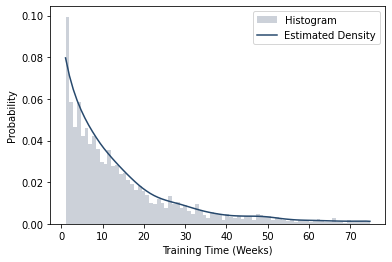

In [ ]:
# Create histogram
fig, ax1 = plt.subplots()
counts, edges, patches = ax1.hist(data['week_train'], bins=bins, range=hist_range, 
                                  weights=np.ones_like(data['week_train']) / len(data['week_train']), 
                                  alpha=0.5, color='#9BA4B4', label='Histogram')

# Plot the local polynomial density estimation
# ax2 = ax1.twinx()  # Create a second y-axis
ax1.plot(density_est.Estimate.grid,density_est.Estimate.f_p, label='Estimated Density', color='#27496D')
# ax1.set_ylabel('Density')
# ax1.legend(loc='upper right')

ax1.set_xlabel('Training Time (Weeks)')
ax1.set_ylabel('Probability')
ax1.legend(loc='upper right')

plt.show()

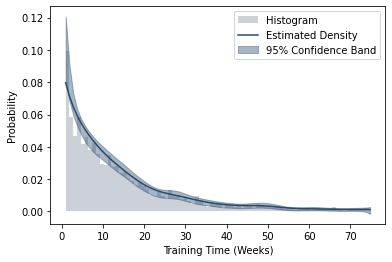

In [65]:
ci = density_est.confint(alpha=0.05, CIuniform=True)        # 95 % uniform band
ci_lower = ci['CI_l_q']                                        # column names used by lpdensity
ci_upper = ci['CI_r_q']

# (b) Manual fallback (pointwise band) – keep only if you disabled bias correction
# z = norm.ppf(1 - 0.05/2)                                   # 1.96
# ci_lower = density_est.Estimate.f_q - z * density_est.Estimate.se_q
# ci_upper = density_est.Estimate.f_q + z * density_est.Estimate.se_q

# ── 2.  Make the plot ─────────────────────────────────────────────────────────
fig, ax1 = plt.subplots()

# Histogram (probability‐scaled)
ax1.hist(
    data['week_train'],
    bins=bins,
    range=hist_range,
    weights=np.ones_like(data['week_train']) / len(data['week_train']),
    alpha=0.5,
    color='#9BA4B4',
    label='Histogram',
)

# Estimated density
ax1.plot(
    density_est.Estimate.grid,
    density_est.Estimate.f_p,
    color='#27496D',
    label='Estimated Density',
)

# Confidence band (shaded)
ax1.fill_between(
    density_est.Estimate.grid,
    ci_lower,
    ci_upper,
    color='#27496D',
    alpha=0.40,
    label='95% Confidence Band',
)

# Cosmetics
ax1.set_xlabel('Training Time (Weeks)')
ax1.set_ylabel('Probability')
ax1.legend(loc='upper right')
plt.show()

In [ ]:

bins = 80
hist_range = (data['week_train'].min(), data['week_train'].max())
bin_width = (hist_range[1] - hist_range[0]) / bins

# Extract the data
week_train = data['week_train'].values

# Perform local polynomial density estimation
density_est = lpdensity(week_train, bw=[bin_width], grid=np.linspace(hist_range[0], hist_range[1], bins))



AssertionError: 

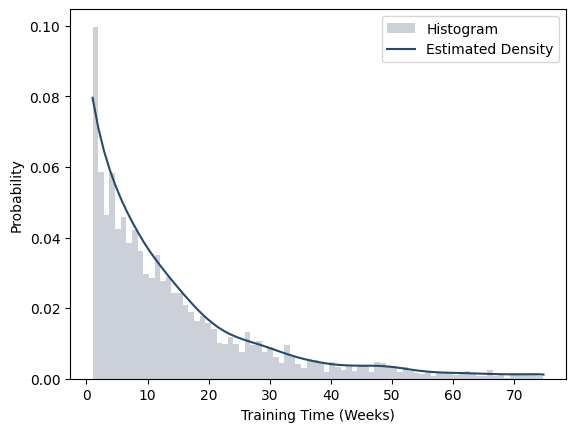

In [ ]:
# Create histogram
fig, ax1 = plt.subplots()
counts, edges, patches = ax1.hist(data['week_train'], bins=bins, range=hist_range, 
                                  weights=np.ones_like(data['week_train']) / len(data['week_train']), 
                                  alpha=0.5, color='#9BA4B4', label='Histogram')

# Plot the local polynomial density estimation
# ax2 = ax1.twinx()  # Create a second y-axis
ax1.plot(density_est.Estimate.grid,density_est.Estimate.f_p, label='Estimated Density', color='#27496D')
# ax1.set_ylabel('Density')
# ax1.legend(loc='upper right')

ax1.set_xlabel('Training Time (Weeks)')
ax1.set_ylabel('Probability')
ax1.legend(loc='upper right')

plt.show()

### Rademacher complexity

In [2]:
wel_est_dict = {}
wel_test_dict = {}
wel_pen_dict = {}
beta_dict = {}
for k in range(1, 10):
    for k2 in range(10, 20):
        with open(f'results_rad_241121/results_{k}_{k2}.pkl', 'rb') as f:
            temp_res = pickle.load(f)
            wel_test_dict[(k, k2)] = temp_res['welfare']
            wel_pen_dict[(k, k2)] = temp_res['penalized_obj']
            beta_dict[(k, k2)] = temp_res['coefficient']




In [3]:
sorted_items = sorted(wel_pen_dict.items(), key=lambda x: x[1], reverse=True)

# Print all keys and values in sorted order
for (k, k2), value in sorted_items:
    print(f"Location (k,k2): ({k},{k2}), Value: {value}")

Location (k,k2): (4,10), Value: 317311.0181242893
Location (k,k2): (3,10), Value: 297823.1482146867
Location (k,k2): (2,10), Value: 293631.48369438655
Location (k,k2): (5,10), Value: 293549.11318596336
Location (k,k2): (1,10), Value: 291843.0290331177
Location (k,k2): (7,10), Value: 286405.6832897816
Location (k,k2): (5,11), Value: 286169.12836635666
Location (k,k2): (9,10), Value: 285195.46148540307
Location (k,k2): (7,11), Value: 282033.5211441109
Location (k,k2): (8,10), Value: 280331.6318835906
Location (k,k2): (2,11), Value: 269501.5748215924
Location (k,k2): (6,10), Value: 265882.70968536806
Location (k,k2): (9,12), Value: 265879.93681108806
Location (k,k2): (1,11), Value: 265690.554624216
Location (k,k2): (4,11), Value: 265615.3503574004
Location (k,k2): (9,11), Value: 265425.0698141173
Location (k,k2): (5,12), Value: 264602.24134577665
Location (k,k2): (4,12), Value: 261374.74789168703
Location (k,k2): (6,11), Value: 259120.84845322053
Location (k,k2): (3,11), Value: 259004.320

In [6]:
with open(f'input_rad_1120.pkl', 'rb') as f:
    input = pickle.load(f)



In [7]:
X_policy = input['x_pol']
t_lo = input['t_lo']
t_hi = input['t_hi']


In [8]:
N, P1 = X_policy.shape


In [9]:
clip_pi = {}
for K in range(1, 10):
    for k2 in range(10, 1):
    # (K, k2) = sorted_items[i][0]
# for K in range(1, 11):
#     for k2 in range(1, 21):
        # k2 = k_h_pair[K]
        beta = beta_dict[(K, k2)]
        beta = np.array([[beta[(k,p)] for p in range(P1)] for k in range(K+1)])
        N = 50
        x_cont1 = np.linspace(0, np.max(X_policy[:,0]), N)
        x_cont2 = np.linspace(np.min(X_policy[:,1]), np.max(X_policy[:,1]), N)
        x_cont3 = np.linspace(np.min(X_policy[:,2]), np.max(X_policy[:,2]), N)
        X1, X2, X3 = np.meshgrid(x_cont1, x_cont2, x_cont3)
        x_cont = np.array(pd.DataFrame({'edu': x_cont1, 'pre-earning': x_cont2, 'experience':x_cont3}))
        x_scale = np.zeros((N, P1))
        x_scale = np.max(x_cont, axis = 0) - np.min(x_cont, axis = 0)
        pi = np.zeros((N, N, N))
        for i in range(N):
            for j in range(N):
                for l in range(N):
                    phi = np.zeros((K+1, P1))
                    for k in range(K+1):
                        x_cont_temp = np.array([X1[i,j,l], X2[i,j,l], X3[i,j,l]])
                        phi[k,:] = (x_scale - np.abs(K*(x_cont_temp - np.min(x_cont, axis = 0))- k*x_scale)) * ((k - 1)*x_scale <= K*(x_cont_temp - np.min(x_cont, axis = 0))) * ((k+1)*x_scale >= K*(x_cont_temp - np.min(x_cont, axis = 0)))
                    pi[i,j,l] = np.sum(beta * phi) 
        clip_pi[(k, k2)] = np.clip(pi, t_lo, t_hi)

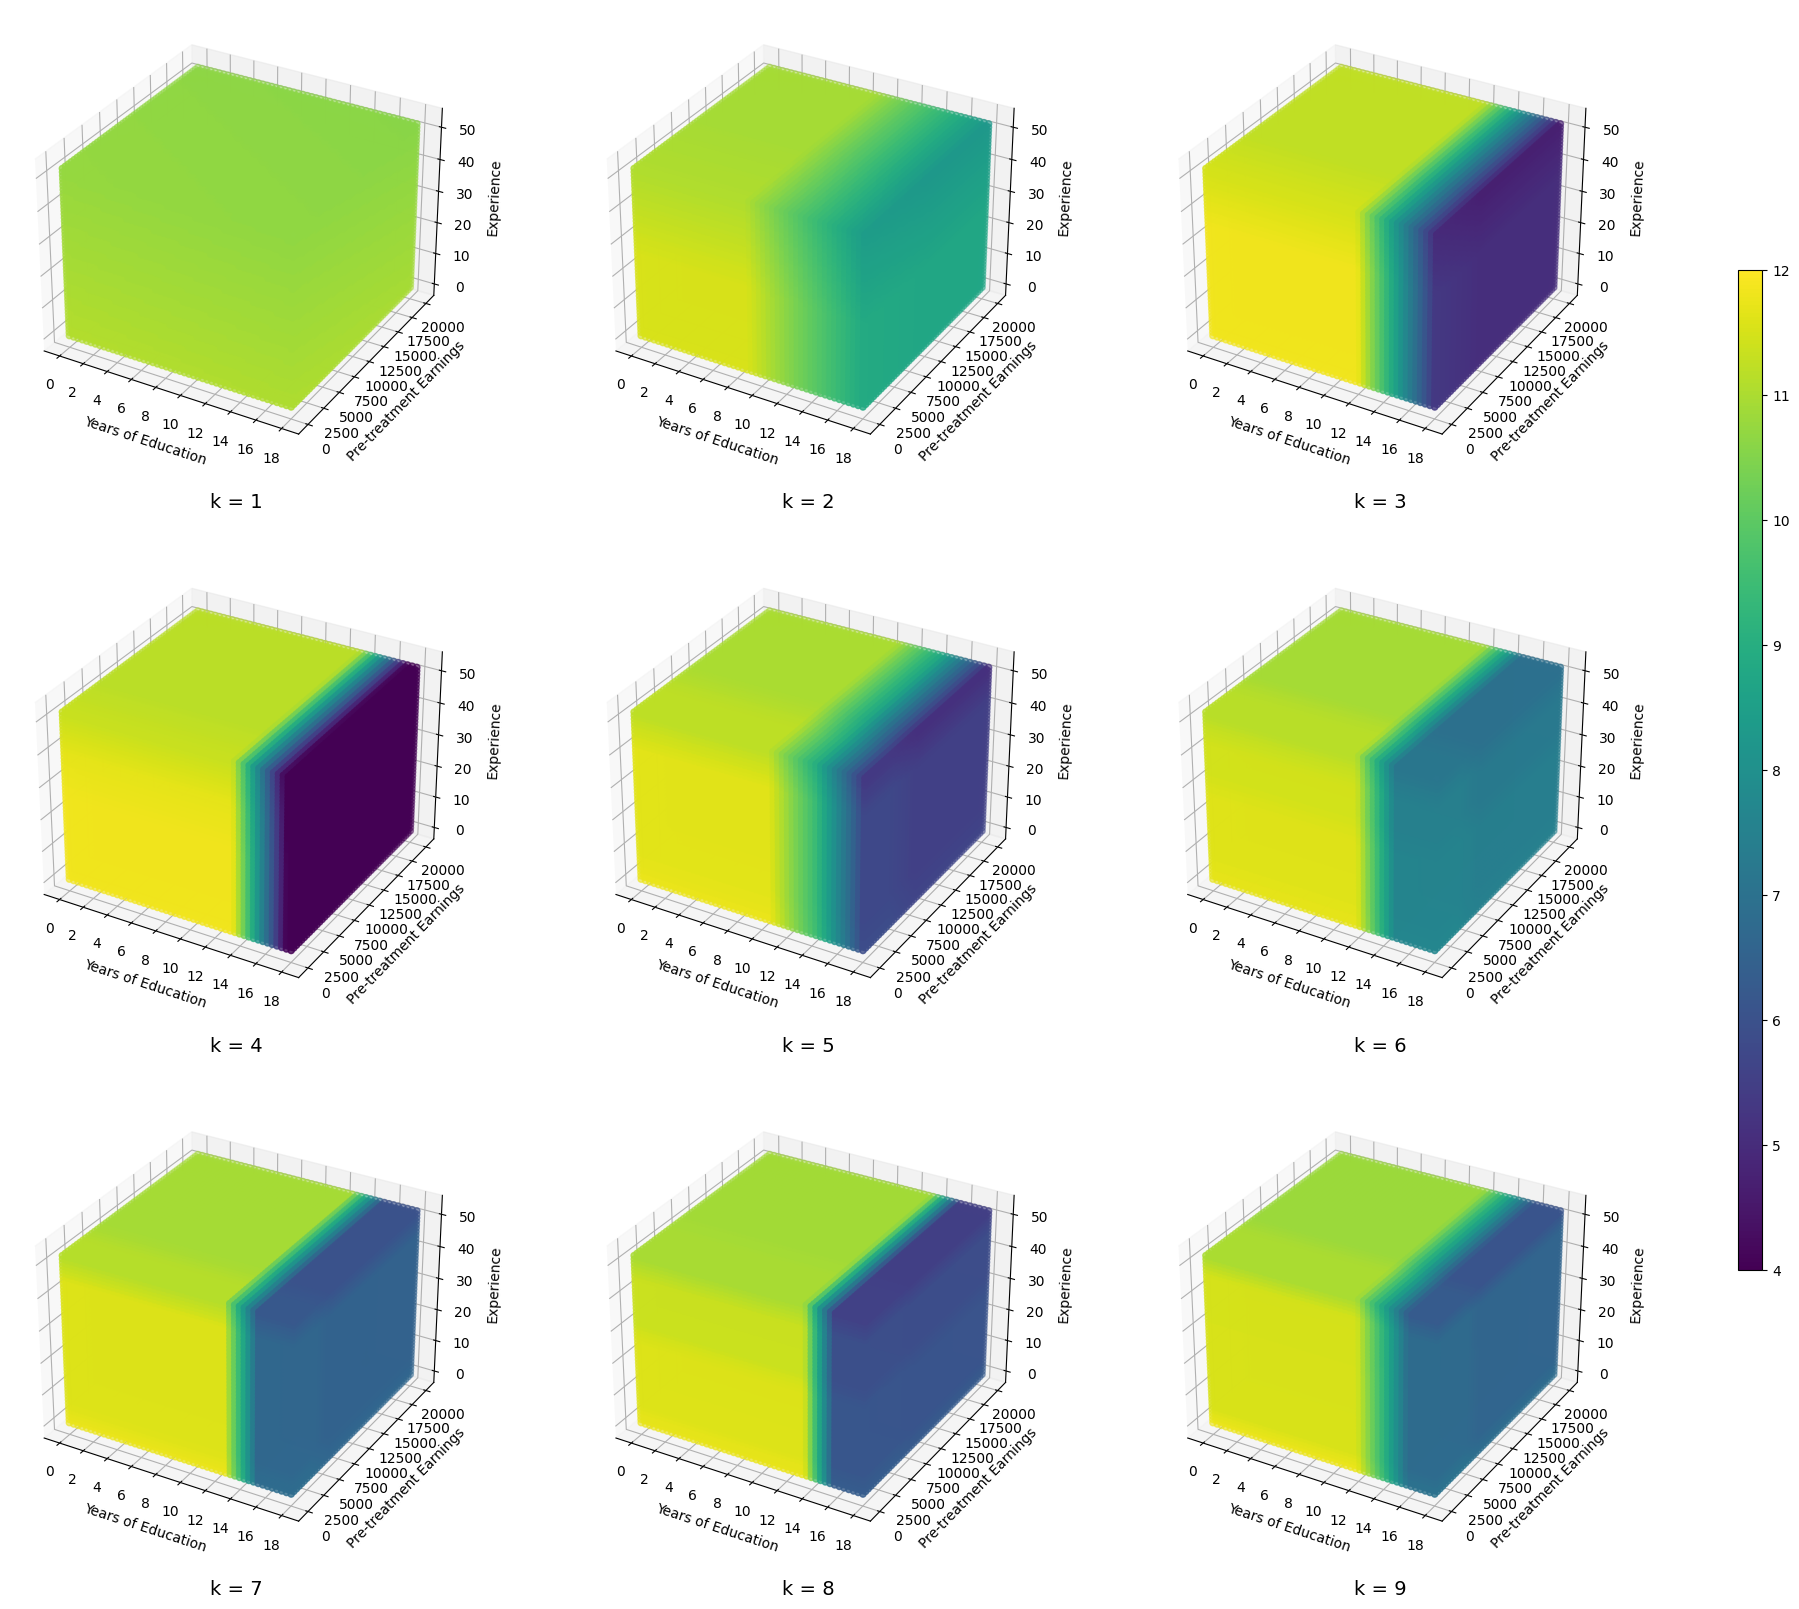

In [10]:
fig = plt.figure(figsize=(24, 20))  # Adjust the size as needed
k_values = range(1, 10)
k2_values = range(10, 11)

global_min = min([clip_pi[(k, k2)].min() for k in k_values for k2 in k2_values])
global_max = max([clip_pi[(k, k2)].max() for k in k_values for k2 in k2_values])

i = 0
for k in range(1, 10):
    for k2 in range(10, 11):
    # (K, k2) = sorted_items[i][0]
        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        p = ax.scatter(X1.flatten(), X2.flatten(), X3.flatten(), c=clip_pi[(k, k2)].flatten(), cmap='viridis', vmin=4, vmax=12)
        ax.set_xlabel('Years of Education')
        ax.set_ylabel('Pre-treatment Earnings')
        ax.set_zlabel('Experience')
        ax.text2D(0.5, -0.1, f"k = {k}", transform=ax.transAxes, ha='center', fontsize=14)
        # Set integer ticks on x-axis
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        i += 1
# Add a single colorbar for all subplots
fig.subplots_adjust(right=0.8)  # Adjust the main figure to make room for the colorbar
cbar_ax = fig.add_axes([0.85, 0.25, 0.01, 0.5])  # Position the colorbar
fig.colorbar(p, cax=cbar_ax)
plt.show()

### Holdout penalty

In [11]:
wel_est_dict_hold = {}
wel_test_dict_hold = {}
wel_pen_dict_hold = {}
beta_dict_hold = {}
for k in range(1, 10):
    for k2 in range(1, 2):
        with open(f'results_holdout_241123/results_{k}_{k2}.pkl', 'rb') as f:
            temp_res = pickle.load(f)
            wel_test_dict_hold[(k, k2)] = temp_res['welfare_test']
            wel_pen_dict_hold[(k, k2)] = temp_res['penalized_obj']
            beta_dict_hold[(k, k2)] = temp_res['coefficient']




In [12]:
sorted_items_hold = sorted(wel_pen_dict_hold.items(), key=lambda x: x[1], reverse=True)

# Print all keys and values in sorted order
for (k, k2), value in sorted_items_hold:
    print(f"Location (k,k2): ({k},{k2}), Value: {value}")

Location (k,k2): (5,1), Value: 220165.89001791255
Location (k,k2): (3,1), Value: 82859.67064866982
Location (k,k2): (1,1), Value: 29633.73315658654
Location (k,k2): (4,1), Value: 19219.050673635225
Location (k,k2): (9,1), Value: -15940.252768160708
Location (k,k2): (7,1), Value: -22417.757835406563
Location (k,k2): (6,1), Value: -29102.790933837307
Location (k,k2): (8,1), Value: -31633.938699921804
Location (k,k2): (2,1), Value: -46110.97274503345


In [13]:
with open(f'input_1123.pkl', 'rb') as f:
    input = pickle.load(f)

data_est_dict = input['data_estimation']
data_test_dict = input['data_testing']



In [14]:
X_policy_hold = data_test_dict['x_pol']
t_lo_hold = data_test_dict['t_lo']
t_hi_hold = data_test_dict['t_hi']


In [15]:
N_hold, P1_hold = X_policy_hold.shape


In [16]:
clip_pi_hold = {}
for K in range(1, 10):
    for k2 in range(1, 2):
    # (K, k2) = sorted_items[i][0]
# for K in range(1, 11):
#     for k2 in range(1, 21):
        # k2 = k_h_pair[K]
        beta_hold = beta_dict_hold[(K, k2)]
        beta_hold = np.array([[beta_hold[(k,p)] for p in range(P1_hold)] for k in range(K+1)])
        N = 50
        x_cont1_hold = np.linspace(0, np.max(X_policy[:,0]), N)
        x_cont2_hold = np.linspace(np.min(X_policy[:,1]), np.max(X_policy[:,1]), N)
        x_cont3_hold = np.linspace(np.min(X_policy[:,2]), np.max(X_policy[:,2]), N)
        X1_hold, X2_hold, X3_hold = np.meshgrid(x_cont1_hold, x_cont2_hold, x_cont3_hold)
        x_cont_hold = np.array(pd.DataFrame({'edu': x_cont1_hold, 'pre-earning': x_cont2_hold, 'experience':x_cont3_hold}))
        x_scale_hold = np.zeros((N, P1_hold))
        x_scale_hold = np.max(x_cont_hold, axis = 0) - np.min(x_cont_hold, axis = 0)
        pi_hold = np.zeros((N, N, N))
        for i in range(N):
            for j in range(N):
                for l in range(N):
                    phi_hold = np.zeros((K+1, P1_hold))
                    for k in range(K+1):
                        x_cont_temp = np.array([X1_hold[i,j,l], X2_hold[i,j,l], X3_hold[i,j,l]])
                        phi_hold[k,:] = (x_scale_hold - np.abs(K*(x_cont_temp - np.min(x_cont_hold, axis = 0))- k*x_scale_hold)) * ((k - 1)*x_scale_hold <= K*(x_cont_temp - np.min(x_cont_hold, axis = 0))) * ((k+1)*x_scale_hold >= K*(x_cont_temp - np.min(x_cont_hold, axis = 0)))
                    pi_hold[i,j,l] = np.sum(beta_hold * phi_hold) 
        clip_pi_hold[(k, k2)] = np.clip(pi_hold, t_lo_hold, t_hi_hold)

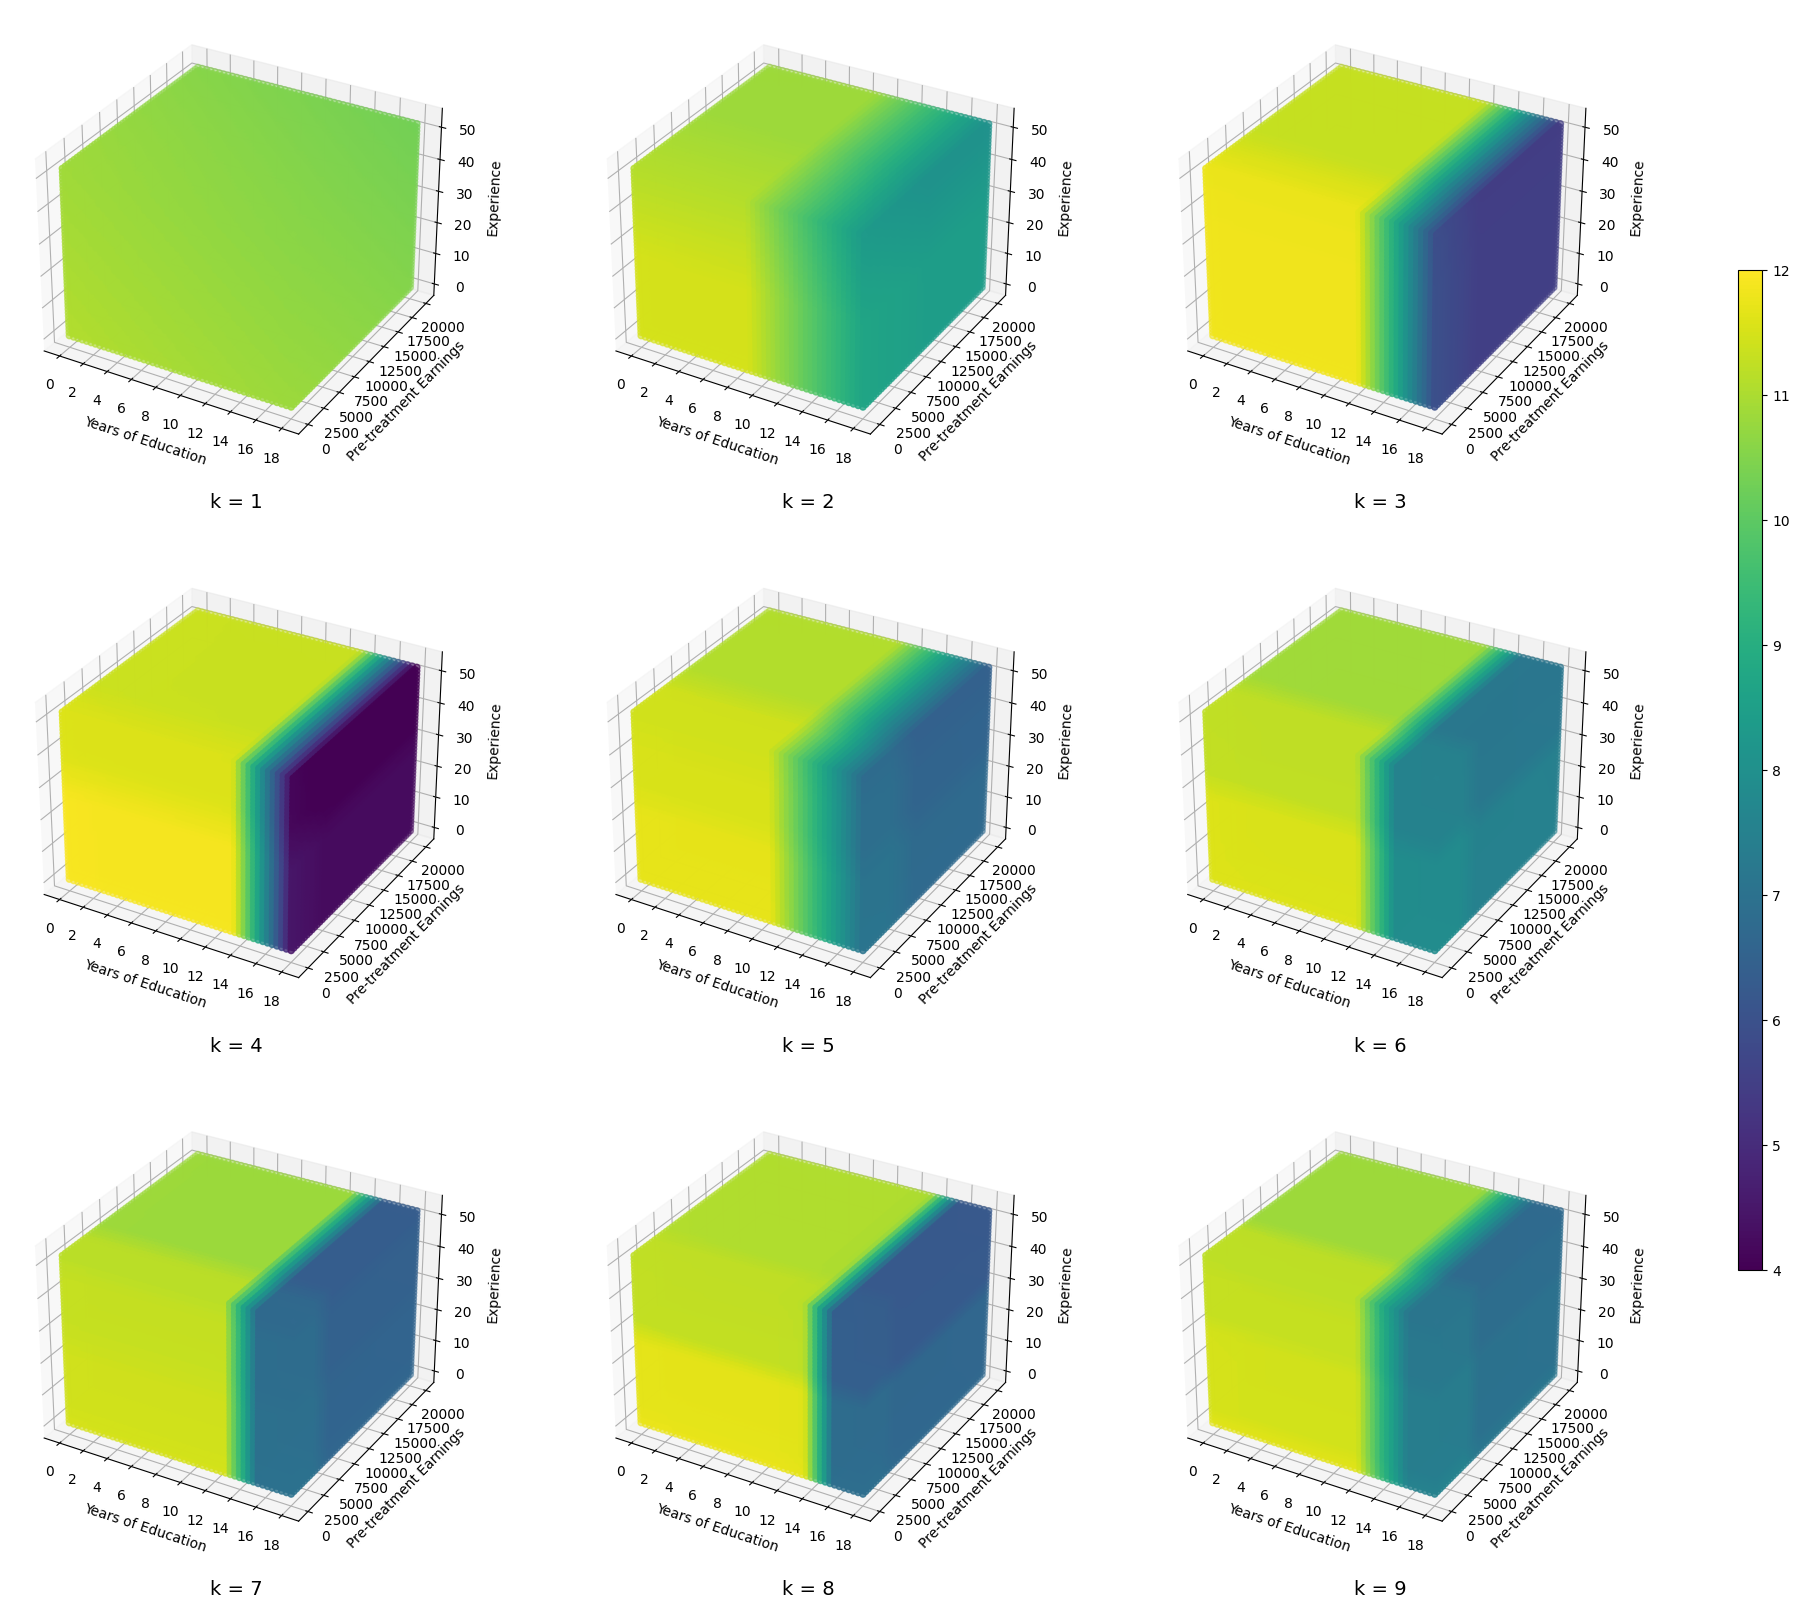

In [17]:
fig = plt.figure(figsize=(24, 20))  # Adjust the size as needed
k_values = range(1, 10)
k2_values = range(1, 2)

global_min_hold = min([clip_pi_hold[(k, k2)].min() for k in k_values for k2 in k2_values])
global_max_hold = max([clip_pi_hold[(k, k2)].max() for k in k_values for k2 in k2_values])

i = 0
for k in range(1, 10):
    for k2 in range(1, 2):
    # (K, k2) = sorted_items[i][0]
        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        p = ax.scatter(X1_hold.flatten(), X2_hold.flatten(), X3_hold.flatten(), c=clip_pi_hold[(k, k2)].flatten(), cmap='viridis', vmin=4, vmax=12)
        ax.set_xlabel('Years of Education')
        ax.set_ylabel('Pre-treatment Earnings')
        ax.set_zlabel('Experience')
        ax.text2D(0.5, -0.1, f"k = {k}", transform=ax.transAxes, ha='center', fontsize=14)
        # Set integer ticks on x-axis
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        i += 1
# Add a single colorbar for all subplots
fig.subplots_adjust(right=0.8)  # Adjust the main figure to make room for the colorbar
cbar_ax = fig.add_axes([0.85, 0.25, 0.01, 0.5])  # Position the colorbar
fig.colorbar(p, cax=cbar_ax)
plt.show()

### Slices

In [48]:
clip_pi = {}
K = 4
k2 = 10


beta = beta_dict[(K, k2)]
beta = np.array([[beta[(k,p)] for p in range(P1)] for k in range(K+1)])
N = 50
x_cont1 = np.linspace(0, np.max(X_policy[:,0]), N)
x_cont2 = np.linspace(np.min(X_policy[:,1]), np.max(X_policy[:,1]), N)
x_cont3 = np.linspace(np.min(X_policy[:,2]), np.max(X_policy[:,2]), N)


x_cont = np.array(pd.DataFrame({'edu': x_cont1, 'pre-earning': x_cont2, 'experience':x_cont3}))
x_scale = np.zeros((N, P1))
x_scale = np.max(x_cont, axis = 0) - np.min(x_cont, axis = 0)
pi = np.zeros((N, N, N))
for i in range(N):
    for j in range(N):
        for l in range(N):
            phi = np.zeros((K+1, P1))
            for k in range(K+1):
                x_cont_temp = np.array([x_cont1[i], x_cont2[j], x_cont3[l]])
                phi[k,:] = (x_scale - np.abs(K*(x_cont_temp - np.min(x_cont, axis = 0))- k*x_scale)) * ((k - 1)*x_scale <= K*(x_cont_temp - np.min(x_cont, axis = 0))) * ((k+1)*x_scale >= K*(x_cont_temp - np.min(x_cont, axis = 0)))
            pi[i,j,l] = np.sum(beta * phi) 
clip_pi[(k, k2)] = np.clip(pi, t_lo, t_hi)

In [68]:

clip_pi_hold = {}
K_hold = 5
k2_hold = 1     
beta_hold = beta_dict_hold[(K_hold, k2_hold)]
beta_hold = np.array([[beta_hold[(k,p)] for p in range(P1_hold)] for k in range(K_hold+1)])
N = 50
x_cont1_hold = np.linspace(0, np.max(X_policy[:,0]), N)
x_cont2_hold = np.linspace(np.min(X_policy[:,1]), np.max(X_policy[:,1]), N)
x_cont3_hold = np.linspace(np.min(X_policy[:,2]), np.max(X_policy[:,2]), N)

x_cont_hold = np.array(pd.DataFrame({'edu': x_cont1_hold, 'pre-earning': x_cont2_hold, 'experience':x_cont3_hold}))
x_scale_hold = np.zeros((N, P1_hold))
x_scale_hold = np.max(x_cont_hold, axis = 0) - np.min(x_cont_hold, axis = 0)
pi_hold = np.zeros((N, N, N))
for i in range(N):
    for j in range(N):
        for l in range(N):
            phi_hold = np.zeros((K_hold+1, P1_hold))
            for k in range(K_hold+1):
                x_cont_temp = np.array([x_cont1[i], x_cont2[j], x_cont3[l]])
                phi_hold[k,:] = (x_scale_hold - np.abs(K_hold*(x_cont_temp - np.min(x_cont_hold, axis = 0))- k*x_scale_hold)) * ((k - 1)*x_scale_hold <= K_hold*(x_cont_temp - np.min(x_cont_hold, axis = 0))) * ((k+1)*x_scale_hold >= K_hold*(x_cont_temp - np.min(x_cont_hold, axis = 0)))
            pi_hold[i,j,l] = np.sum(beta_hold * phi_hold) 
clip_pi_hold[(K_hold, k2_hold)] = np.clip(pi_hold, t_lo_hold, t_hi_hold)


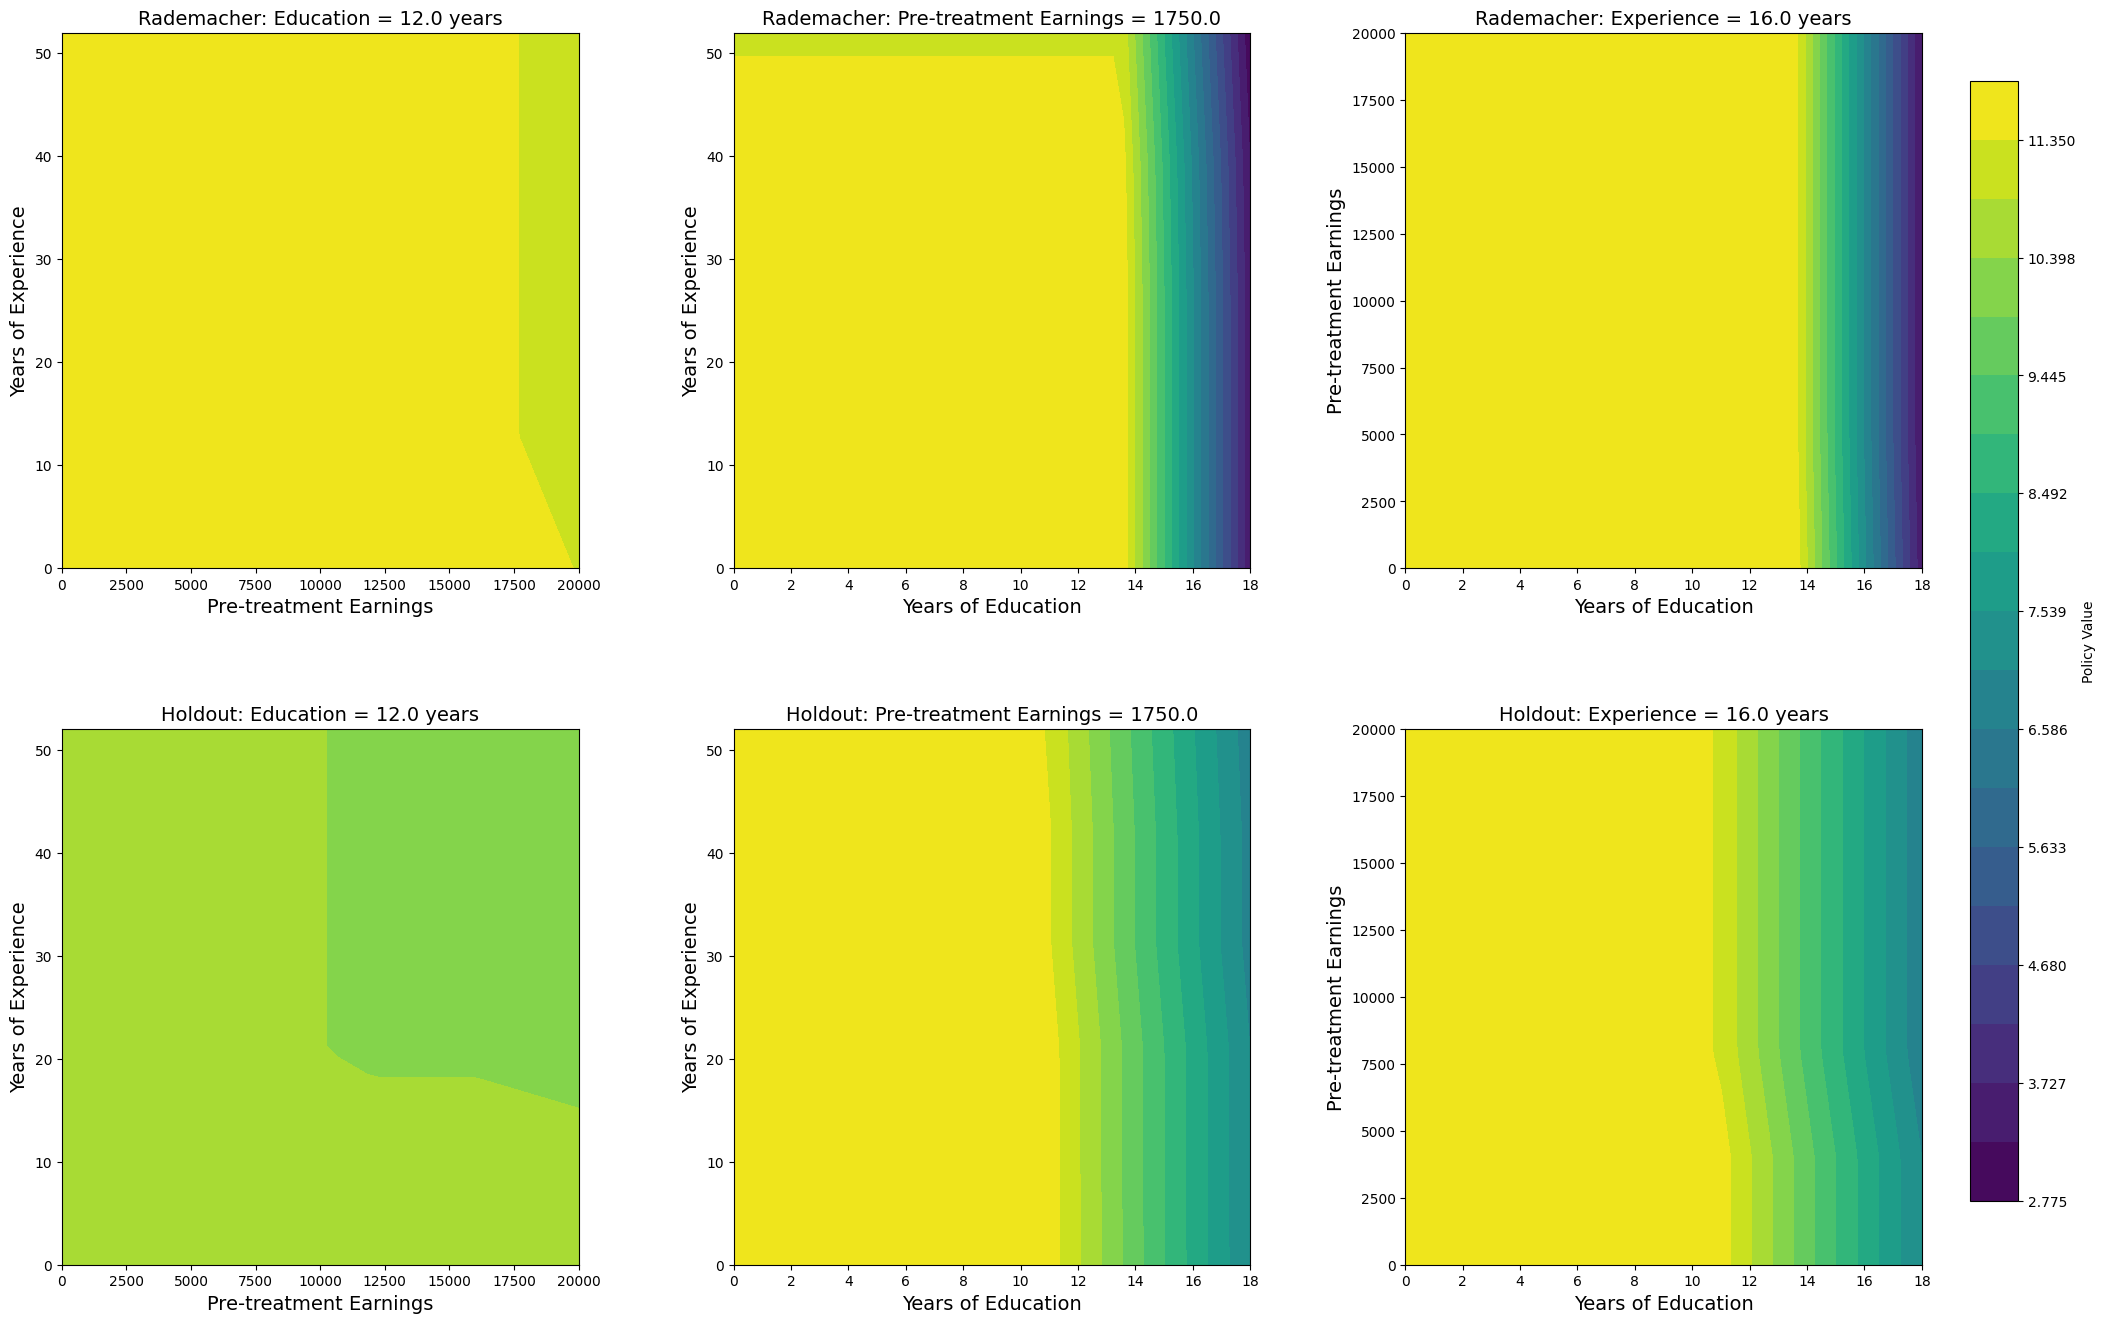

In [76]:
# Create a single figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(24,16))

# Get median values and indices
x1_med = np.median(X_policy[:,0])
x1_idx = np.argmin(np.abs(x_cont1 - x1_med))
x2_med = np.median(X_policy[:,1])
x2_idx = np.argmin(np.abs(x_cont2 - x2_med))
x3_med = np.median(X_policy[:,2])
x3_idx = np.argmin(np.abs(x_cont3 - x3_med))

# Calculate global min/max for consistent coloring across all plots
vmin = min(np.min(clip_pi[(K,k2)]), np.min(clip_pi_hold[(K_hold,k2_hold)]))
vmax = max(np.max(clip_pi[(K,k2)]), np.max(clip_pi_hold[(K_hold,k2_hold)]))
levels = np.linspace(vmin, vmax, 20)
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# First row - Rademacher complexity
im1 = axes[0,0].contourf(x_cont2, x_cont3, clip_pi[(K,k2)][x1_idx,:,:],
                      levels=levels, cmap='viridis', norm=norm)
axes[0,0].set_xlabel('Pre-treatment Earnings', fontsize = 14)
axes[0,0].set_ylabel('Years of Experience', fontsize = 14)
axes[0,0].set_title(f'Rademacher: Education = {x1_med:.1f} years', fontsize = 14)

im2 = axes[0,1].contourf(x_cont1, x_cont3, clip_pi[(K,k2)][:,x2_idx,:].T,
                      levels=levels, cmap='viridis', norm=norm)
axes[0,1].set_xlabel('Years of Education', fontsize = 14)
axes[0,1].set_ylabel('Years of Experience', fontsize = 14)
axes[0,1].set_title(f'Rademacher: Pre-treatment Earnings = {x2_med:.1f}', fontsize = 14)

im3 = axes[0,2].contourf(x_cont1, x_cont2, clip_pi[(K,k2)][:,:,x3_idx].T,
                      levels=levels, cmap='viridis', norm=norm)
axes[0,2].set_xlabel('Years of Education', fontsize = 14)
axes[0,2].set_ylabel('Pre-treatment Earnings', fontsize = 14)
axes[0,2].set_title(f'Rademacher: Experience = {x3_med:.1f} years', fontsize = 14)

# Second row - Holdout
im4 = axes[1,0].contourf(x_cont2, x_cont3, clip_pi_hold[(K_hold,k2_hold)][x1_idx,:,:],
                      levels=levels, cmap='viridis', norm=norm)
axes[1,0].set_xlabel('Pre-treatment Earnings', fontsize = 14)
axes[1,0].set_ylabel('Years of Experience', fontsize = 14)
axes[1,0].set_title(f'Holdout: Education = {x1_med:.1f} years', fontsize = 14)

im5 = axes[1,1].contourf(x_cont1, x_cont3, clip_pi_hold[(K_hold,k2_hold)][:,x2_idx,:].T,
                      levels=levels, cmap='viridis', norm=norm)
axes[1,1].set_xlabel('Years of Education', fontsize = 14)
axes[1,1].set_ylabel('Years of Experience', fontsize = 14)
axes[1,1].set_title(f'Holdout: Pre-treatment Earnings = {x2_med:.1f}', fontsize = 14)

im6 = axes[1,2].contourf(x_cont1, x_cont2, clip_pi_hold[(K_hold,k2_hold)][:,:,x3_idx].T,
                      levels=levels, cmap='viridis', norm=norm)
axes[1,2].set_xlabel('Years of Education', fontsize = 14)
axes[1,2].set_ylabel('Pre-treatment Earnings', fontsize = 14)
axes[1,2].set_title(f'Holdout: Experience = {x3_med:.1f} years', fontsize = 14)

# Add single colorbar
plt.subplots_adjust(right=0.9, wspace=0.3, hspace=0.3)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax, label='Policy Value')

plt.show()